In [4]:
import pandas as pd
import matplotlib.pyplot as plt
#from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import seaborn as sb
import numpy as np
from scipy.sparse import csr_matrix

In [5]:
#loading the movies dataset and storing it in movies
movies = pd.read_csv('rec_system/movies.xls')

In [6]:
#checking if it loads and correctly 
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
#reading the rating dataset and storing it in ratings 
ratings = pd.read_csv('rec_system/ratings.csv', sep =",")

In [8]:
# checking if it loads and correctly 
ratings.head()

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523


In [9]:
#functing to drop a row or column 
def drop(df, col, axis):
    return df.drop(col, axis=axis, inplace = True)

In [10]:
# checking the number of rows and columns
ratings.shape

(105339, 4)

* there are 105339 user ratings (rows) and four columns

In [11]:
#checking the number of rows and columns in the movies dataframe 
movies.shape

(10329, 3)

<b> there are 10329 movies that were rated </b>

In [12]:
#randomly checking the movies dataframe to see if there are errors in the dataframe content
movies.sample(5)

,movieId,title,genres
2677,3375,Destination Moon (1950),Sci-Fi
8552,77780,Virtuality (2009),Drama|Sci-Fi|Thriller
3632,4638,Jurassic Park III (2001),Action|Adventure|Sci-Fi|Thriller
7659,58376,Zeitgeist: The Movie (2007),Documentary|War
6548,32456,"Pom Poko (a.k.a. Raccoon War, The) (Heisei tan...",Animation|Comedy|Drama|Fantasy


In [13]:
#randomly checking the ratings dataframe to see if there are errors in the dataframe content 
ratings.sample(5)

,userId,movieId,rating,timestamp
58935,415,27773,5.0,1341263300
96850,637,3700,2.0,983918454
24000,177,5502,5.0,1074042861
20284,160,78,4.0,903570742
17904,138,48,4.0,835879453


In [14]:
# checking the number of users that rated movieId 2094
print(movies[movies['movieId']== 2094].title)
len(ratings[ratings['movieId']==2094])

1653    Rocketeer, The (1991)
Name: title, dtype: object


43

movie title is Rocketeer and 43 users rated the movie

In [15]:
print(movies.title[movies['movieId']==590])
len(ratings[ratings['movieId']==590])

523    Dances with Wolves (1990)
Name: title, dtype: object


201

In [16]:
# checking for null values
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [17]:
# checking for null values
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

201 users rated Dance with Wolves

In [18]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105339 entries, 0 to 105338
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     105339 non-null  int64  
 1   movieId    105339 non-null  int64  
 2   rating     105339 non-null  float64
 3   timestamp  105339 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.2 MB


In [19]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10329 entries, 0 to 10328
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  10329 non-null  int64 
 1   title    10329 non-null  object
 2   genres   10329 non-null  object
dtypes: int64(1), object(2)
memory usage: 242.2+ KB


In [20]:
ratings.describe()

,userId,movieId,rating,timestamp
count,105339.000000,105339.000000,105339.000000,1.053390e+05
mean,364.924539,13381.312477,3.516850,1.130424e+09
std,197.486905,26170.456869,1.044872,1.802660e+08
min,1.000000,1.000000,0.500000,8.285650e+08
25%,192.000000,1073.000000,3.000000,9.711008e+08
50%,383.000000,2497.000000,3.500000,1.115154e+09
75%,557.000000,5991.000000,4.000000,1.275496e+09
max,668.000000,149532.000000,5.000000,1.452405e+09


1. minimum ratings is 0.5 which suggest outlier since the scale is from 0 t0 5
2. average rating is 3.5
3. std is small suggesting points are not too far from mean and data is not or fairly skewed 

In [21]:
# getting categories of movie genre and movie titles in both dataframes
genres = []
for genre in movies.genres:
    x = genre.split('|')
    for i in x:
        if i not in genres:
            genres.append(str(i))
genres=str(genres)    
movie_title=[]
for title in movies.title:
    movie_title.append(title[0:-7])
movie_title=str(movie_title)    
        

In [22]:
genres

"['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Mystery', 'Sci-Fi', 'IMAX', 'War', 'Musical', 'Documentary', 'Western', 'Film-Noir', '(no genres listed)']"

In [23]:
#mergining the two tables/dataframes, joining it on the left of ratings using movieID
df=pd.merge(ratings,movies, how='left',on='movieId')
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,16,4.0,1217897793,Casino (1995),Crime|Drama
1,1,24,1.5,1217895807,Powder (1995),Drama|Sci-Fi
2,1,32,4.0,1217896246,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,1,47,4.0,1217896556,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,4.0,1217896523,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [24]:
# getting the first 20 highly rated movies
df1=df.groupby(['title'])[['rating']].sum()
high_rated=df1.nlargest(20,'rating')
high_rated.head()


,rating
title,
"Shawshank Redemption, The (1994)",1372.0
Pulp Fiction (1994),1352.0
Forrest Gump (1994),1287.0
"Silence of the Lambs, The (1991)",1216.5
Star Wars: Episode IV - A New Hope (1977),1143.5


<BarContainer object of 20 artists>

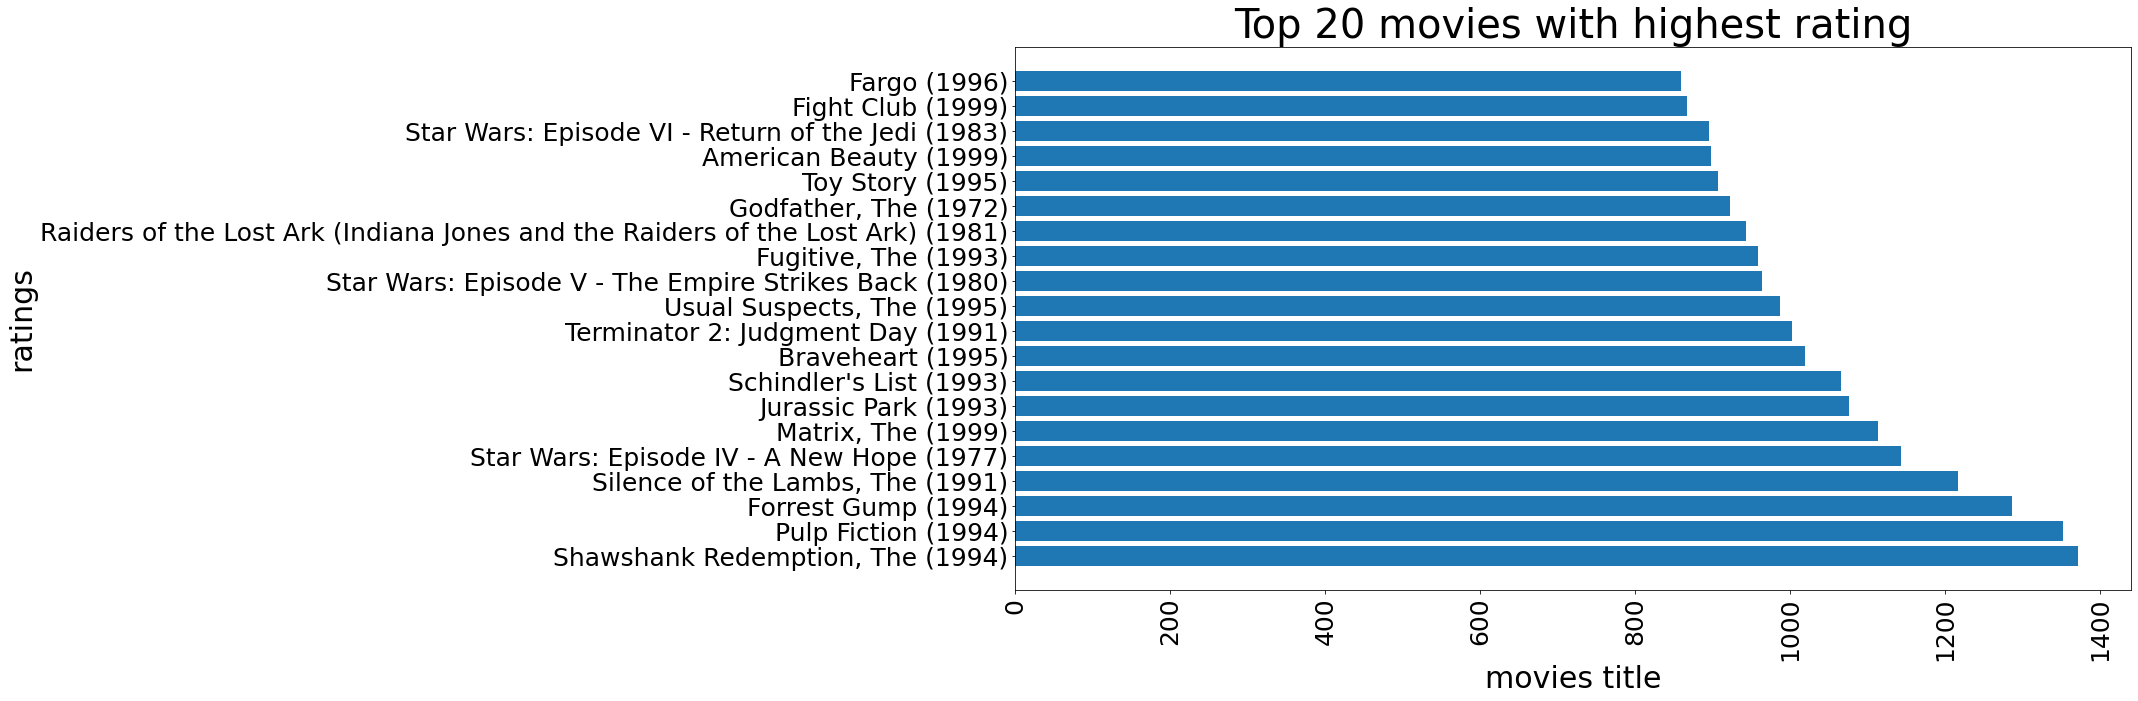

In [25]:
plt.figure(figsize=(20,10))
plt.title('Top 20 movies with highest rating',fontsize=40)
plt.ylabel('ratings',fontsize=30)
plt.xticks(fontsize=25,rotation=90)
plt.xlabel('movies title',fontsize=30)
plt.yticks(fontsize=25)
plt.barh(high_rated.index,high_rated['rating'])

In [26]:
df2=df.groupby('title')[['rating']].count()
rating_count_20=df2.nlargest(20,'rating')
rating_count_20.head()

,rating
title,
Pulp Fiction (1994),325
Forrest Gump (1994),311
"Shawshank Redemption, The (1994)",308
Jurassic Park (1993),294
"Silence of the Lambs, The (1991)",290


In [27]:
# plt.figure(figsize=(30,10))
# plt.title('Top 20 movies with highest number of ratings',fontsize=30)
# plt.xticks(fontsize=25,rotation=90)
# plt.yticks(fontsize=25)
# plt.xlabel('movies title',fontsize=30)
# plt.ylabel('ratings',fontsize=30)
# plt.bar(rating_count_20.index,rating_count_20.rating,color='red')

In [28]:
# generating the term frequency and document frequency vectorization 
cv=TfidfVectorizer()
tfidf_matrix=cv.fit_transform(movies['genres'])

In [29]:
#pivoting the table 
movie_user = df.pivot_table(index='userId',columns='title',values='rating')
movie_user.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...And Justice for All (1979),10 (1979),...,[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),a/k/a Tommy Chong (2005),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
movie_user

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...And Justice for All (1979),10 (1979),...,[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),a/k/a Tommy Chong (2005),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN


sparse table

In [31]:
# generating the cosine similarity between a movie the user wants and others
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [32]:
cosine_sim

array([[1.        , 0.79977247, 0.1589222 , ..., 0.2638368 , 0.        ,
        0.        ],
       [0.79977247, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.1589222 , 0.        , 1.        , ..., 0.60235038, 0.        ,
        0.        ],
       ...,
       [0.2638368 , 0.        , 0.60235038, ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [33]:
indices=pd.Series(movies.index,index=movies['title'])
titles=movies['title']
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [34]:
# movies.title

In [35]:
get_recommendations('Toy Story (1995)')

1815                                       Antz (1998)
2496                                Toy Story 2 (1999)
2967    Adventures of Rocky and Bullwinkle, The (2000)
3166                  Emperor's New Groove, The (2000)
3811                             Monsters, Inc. (2001)
Name: title, dtype: object

## Popularity Recommender Systems 

In [36]:
tfidf = TfidfVectorizer() 

In [37]:
tfidf_matrix = tfidf.fit_transform(movies.genres)

In [38]:
tfidf_matrix.shape

(10329, 24)

In [60]:
from sklearn.metrics.pairwise import linear_kernel

In [61]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [62]:
movies_index = pd.Series(movies.index, index = movies['title']).drop_duplicates()

In [69]:
def get_recommendations(Name, topN):  
    Id = movies_index[Name]
    cosine_scores = list(enumerate(cosine_sim[Id]))
    cosine_scores = sorted(cosine_scores, key=lambda x:x[1], reverse = True)
    cosine_scores_N = cosine_scores[0: topN+1]
    movies_idx  =  [i[0] for i in cosine_scores_N]
    movies_scores =  [i[1] for i in cosine_scores_N]
    similar_movies = pd.DataFrame(columns=["title", "reviews",])
    similar_movies["title"] = movies.loc[movies_idx, "title"]
    reviews = []
    for i in similar_movies.title:
        movie_id = int(movies['movieId'][movies['title'] == i].values)
        num_reviews = len(ratings[ratings['movieId']==movie_id])
        reviews.append(num_reviews)
    similar_movies["reviews"] = reviews
    #similar_movies
    similar_movies.reset_index(inplace = True)
    print (similar_movies)

In [45]:
#movies[movies.title== i] 
#movies[movies.title==i][movies.moviesId]
i = 'Antz (1998)'
movie_id = int(movies['movieId'][movies['title'] == i].values)
movie_id
num_reviews = len(ratings[ratings['movieId']==movie_id])
num_reviews

57

In [70]:
get_recommendations("Toy Story (1995)", topN = 5)

   index                                           title  reviews
0      0                                Toy Story (1995)      232
1   1815                                     Antz (1998)       57
2   2496                              Toy Story 2 (1999)      104
3   2967  Adventures of Rocky and Bullwinkle, The (2000)        8
4   3166                Emperor's New Groove, The (2000)       24
5   3811                           Monsters, Inc. (2001)      116


# collaborative recommended system

In [49]:
df_colla = ratings.pivot(index='movieId',columns='userId',values='rating')
df_colla.head()

userId,1,2,3,4,5,6,7,8,9,10,...,659,660,661,662,663,664,665,666,667,668
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,5.0,NaN,NaN,4.0,NaN,NaN,5.0,NaN,NaN,...,NaN,NaN,4.0,5.0,3.0,NaN,NaN,NaN,NaN,3.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,3.0
3,NaN,2.0,NaN,NaN,NaN,NaN,NaN,4.0,3.0,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,3.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,2.5


In [50]:
df_colla.fillna(0,inplace=True)
df_colla.head()

userId,1,2,3,4,5,6,7,8,9,10,...,659,660,661,662,663,664,665,666,667,668
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,5.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,4.0,5.0,3.0,0.0,0.0,0.0,0.0,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,3.0
3,0.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,3.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5


In [51]:
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')

In [52]:
df_colla = df_colla.loc[no_user_voted[no_user_voted > 10].index,:]

In [53]:
final_dataset=df_colla.loc[:,no_movies_voted[no_movies_voted > 50].index]
final_dataset

userId,1,3,4,5,6,7,8,9,11,15,...,656,657,659,661,662,664,665,666,667,668
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,4.0,0.0,...,0.0,0.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,3.0
3,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5
122882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
122892,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5


In [54]:
csr_data = csr_matrix(final_dataset.values)
final_dataset.reset_index(inplace=True)

In [55]:
from sklearn.neighbors import NearestNeighbors

In [56]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [57]:
def get_movie_recommendation(movie_name):
    n_movies_to_reccomend = 5
    movie_list = movies[movies['title'].str.contains(movie_name)]  
    if len(movie_list):        
        movie_idx= movie_list.iloc[0]['movieId']
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        recommend_frame = []
        for val in rec_movie_indices:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df
    else:
        return "No movies found. Please check your input"

In [58]:
get_movie_recommendation('Memento')

,Title
1,Shrek (2001)
2,"Matrix, The (1999)"
3,American Beauty (1999)
4,"Lord of the Rings: The Fellowship of the Ring,..."
5,Fight Club (1999)
